<a href="https://colab.research.google.com/github/prbocca/meli_ds/blob/main/meli_ds_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Science challenge 

El desafío consta de 5 ejercicios independientes que van desde análisis exploratorio, machine learning o el diseño de una solución de data science.

¿Qué evaluamos?
El desafío busca evaluar distintos aspectos como:
* Capacidad analitica y exploración de datos
* Visualización de resultados
* Conocimientos de técnicas de generación de features y modelado
* Análisis de performance
* Buenas prácticas de desarrollo
* Diseño e implementación de Machine learning en producción

Algunas reglas y recomendaciones:
1. Si bien son 5 ejercicios dejamos a elección del postulante cuales resolver salvo
por el primero que es obligatorio como parte del desafío.
2. Un número recomendado a resolver son 3 de los 5 desafíos, pero sentite libre
de resolver la cantidad deseada.
3. La mayoría de los ejercicios se piden resolver en Jupyter notebooks y te
recomendamos subirlas a un repositorio de GitHub público para compartir los
resultados.
4. No dejes de hacernos preguntas sobre cualquier duda con los enunciados

El desafío se analiza de acuerdo al seniority del postulante y teniendo en cuenta también las necesidades particulares de la posición.

# 3. Similitud entre productos


## Descripción

Un desafío constante en MELI es el de poder agrupar productos similares utilizando algunos atributos de estos como pueden ser el título, la descripción o su imagen.
Para este desafío tenemos un dataset `items_titles.csv` que tiene títulos de 30 mil productos de 3 categorías diferentes de Mercado Libre Brasil.

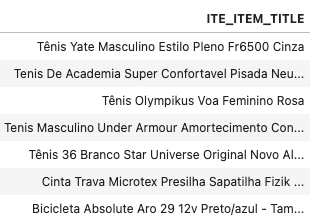




## Entregable
El objetivo del desafío es poder generar una Jupyter notebook que determine cuán similares son dos títulos del dataset `item_titles_test.csv` generando como output un listado de la forma:

| ITE_ITEM_TITLE  | ITE_ITEM_TITLE | Score Similitud (0,1) | 
| --------------- | -------------- | --------------------- | 
|  Zapatillas Nike | Zapatillas Adidas | 0.5 | 
|  Zapatillas Nike | Zapatillas Nike  | 1 | 

donde ordenando por score de similitud podamos encontrar los pares de productos más similares en nuestro dataset de test.



## Asumimos lo siguiente:

* sin asumsiones

In [1]:
# version
from datetime import datetime

print(datetime.now())

2022-10-27 14:52:37.601679


In [2]:
# installs


In [3]:
# liberias

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import random
import os
import shutil
import gc
import bz2
import pickle
import _pickle as cPickle
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import json
import string
import re

import warnings
warnings.filterwarnings('ignore')

import time 
from datetime import datetime, timedelta

import lightgbm as lgb
#import dask_xgboost as xgb
import dask.dataframe as dd
import sklearn as sk
#from sklearn import preprocessing, metrics
#from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual
import ipywidgets as widgets
from IPython.display import display
from tqdm import tnrange, tqdm_notebook

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13) #Setting seed to ensure reproducibility.

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# funciones auxiliares

In [5]:
# configuración

data_filename = 'https://raw.githubusercontent.com/prbocca/meli_ds/main/data/items_titles.csv'
data_filename_test = 'https://raw.githubusercontent.com/prbocca/meli_ds/main/data/items_titles_test.csv'

# Load & preprocessing data

In [6]:
raw_df = pd.read_csv(data_filename, sep=",", engine='python')

display(raw_df.info())
display(raw_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ITE_ITEM_TITLE  30000 non-null  object
dtypes: object(1)
memory usage: 234.5+ KB


None

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...
...,...
29995,Tênis Vans Old Skool I Love My Vans - Usado - ...
29996,Tênis Feminino Preto Moleca 5296155
29997,Tenis Botinha Com Pelo Via Marte Original Lanç...
29998,Tênis Slip On Feminino Masculino Original Sapa...


In [7]:
test_df = pd.read_csv(data_filename_test, sep=",", engine='python')

display(test_df.info())
display(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ITE_ITEM_TITLE  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


None

,ITE_ITEM_TITLE
0,Tênis Olympikus Esporte Valente - Masculino Kids
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...
2,Tênis Usthemp Slip-on Temático - Labrador 2
3,Tênis Casual Feminino Moleca Tecido Tie Dye
4,Tênis Star Baby Sapatinho Conforto + Brinde
...,...
9995,Chuteira Futsal Oxn Velox 3 Infantil
9996,Sapatenis Casual Masculino Estiloso 24horas Co...
9997,Tênis Feminino Infantil Molekinha Tie Dye
9998,Tênis Feminino Leve Barato Ganhe 1 Colchonete ...


In [8]:
# is test in raw?: NO

train_s = set(raw_df['ITE_ITEM_TITLE'].to_list())
test_s = set(test_df['ITE_ITEM_TITLE'].to_list())
print('items de train que no estan en test: ' + str(len(train_s.difference(test_s))))
print('items de test que no estan en train: ' + str(len(test_s.difference(train_s))))

# junto todo para tener un gran dataset
corpus_df = pd.concat([raw_df,test_df]).drop_duplicates()

display(corpus_df.info())
display(corpus_df)

items de train que no estan en test: 28507
items de test que no estan en train: 8507
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38507 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ITE_ITEM_TITLE  38507 non-null  object
dtypes: object(1)
memory usage: 601.7+ KB


None

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...
...,...
9994,Bicicleta Caloi Andes Aro 26 21v
9996,Sapatenis Casual Masculino Estiloso 24horas Co...
9997,Tênis Feminino Infantil Molekinha Tie Dye
9998,Tênis Feminino Leve Barato Ganhe 1 Colchonete ...


Construyo un vector embebido para cada item a partir solo de las palabras en su título.
(podríamos usar otros métodos para embeber, ejemplo CountVectorizer comentado abajo)

In [9]:
# Word Frequencies with TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

stop_words= None # TODO portuguese stop words? 

# create the transform
vectorizer_tfidf = TfidfVectorizer(strip_accents='ascii', lowercase=True, stop_words=stop_words)
# tokenize and build vocab
vectorizer_tfidf.fit(corpus_df['ITE_ITEM_TITLE'])
print('vocabulary: ', vectorizer_tfidf.vocabulary_)
print('idfs: ', vectorizer_tfidf.idf_)

# encode document
vector_tfidf = vectorizer_tfidf.transform(corpus_df['ITE_ITEM_TITLE'])
# summarize encoded vector
print('shape: ', vector_tfidf.shape)
print('vectors: ', vector_tfidf.toarray())

# encode test
vector_test_tfidf = vectorizer_tfidf.transform(test_df['ITE_ITEM_TITLE'])
# summarize encoded vector
print('shape: ', vector_test_tfidf.shape)
print('vectors: ', vector_test_tfidf.toarray())
display(vector_test_tfidf)

vocabulary:  {'tenis': 16732, 'ascension': 5856, 'posh': 14232, 'masculino': 12403, 'preto': 14317, 'vermelho': 17663, 'para': 13719, 'caminhada': 7075, 'super': 16396, 'levinho': 11761, 'spider': 16098, 'corrida': 7992, 'feminino': 9521, 'le': 11687, 'parc': 13725, 'hocks': 10678, 'black': 6385, 'ice': 10796, 'original': 13534, 'envio': 9045, 'ja': 11076, 'olympikus': 13469, 'esportivo': 9138, 'academia': 5178, 'nova': 13300, 'tendencia': 16723, 'triunfo': 17138, 'inteligente': 10979, 'led': 11705, 'bicicleta': 6335, 'tauda': 16624, 'luz': 12097, 'usb': 17440, 'carregave': 7201, 'casual': 7248, 'zarato': 18267, '941': 4950, '632': 4207, 'infantil': 10923, 'ortopasso': 13557, 'conforto': 7876, 'jogging': 11160, 'tv': 17202, 'samsung': 15432, 'qled': 14556, '8k': 4848, 'q800t': 14550, 'semi': 15612, 'usthemp': 17448, 'short': 15740, 'tematico': 16712, 'maria': 12334, 'vira': 17758, 'lata': 11650, 'sapatenis': 15477, 'west': 17974, 'coast': 7710, 'urban': 17405, 'couro': 8038, 'sapatilha

<10000x18348 sparse matrix of type '<class 'numpy.float64'>'
	with 69271 stored elements in Compressed Sparse Row format>

In [10]:
'''
# Word Counts

# opcion sencilla contando palabras sin ponderar importancia

from sklearn.feature_extraction.text import CountVectorizer

stop_words= None # TODO portuguese stop words? 

# create the transform
vectorizer_wc = CountVectorizer(strip_accents='ascii', lowercase=True, stop_words=stop_words)
# tokenize and build vocab
vectorizer_wc.fit(corpus_df['ITE_ITEM_TITLE'])
print('vocabulary: ', vectorizer_wc.vocabulary_)

# encode document
vector_wc = vectorizer_wc.transform(corpus_df['ITE_ITEM_TITLE'])
# summarize encoded vector
print('shape: ', vector_wc.shape)
print('vectors: ', vector_wc.toarray())

# encode test
vector_test_wc = vectorizer_wc.transform(test_df['ITE_ITEM_TITLE'])
# summarize encoded vector
print('shape: ', vector_test_wc.shape)
print('vectors: ', vector_test_wc.toarray())
'''
None

Calculo la distancia coseno entre todos los items de test.
(podríamos usar otra distincia)

In [11]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

dist_test_tfidf = cosine_similarity(vector_test_tfidf) #symmetric distance matrix

display(dist_test_tfidf.shape) #symmetric square distance matrix
display(dist_test_tfidf)

(10000, 10000)

array([[1.        , 0.        , 0.00956259, ..., 0.0106172 , 0.00710209,
        0.03092793],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00956259, 0.        , 1.        , ..., 0.01162734, 0.00777779,
        0.0062934 ],
       ...,
       [0.0106172 , 0.        , 0.01162734, ..., 1.        , 0.03672049,
        0.00698746],
       [0.00710209, 0.        , 0.00777779, ..., 0.03672049, 1.        ,
        0.00467407],
       [0.03092793, 0.        , 0.0062934 , ..., 0.00698746, 0.00467407,
        1.        ]])

Acondiciono la matríz de distancia en el dataframe pedido.

In [12]:
i, j = np.triu_indices(len(test_df), k=1)

score_np = np.array([test_df.iloc[i]['ITE_ITEM_TITLE'],
                     test_df.iloc[j]['ITE_ITEM_TITLE'], 
                     dist_test_tfidf[i,j]]).T
score_df = pd.DataFrame(score_np, columns = ['ITE_ITEM_TITLE1','ITE_ITEM_TITLE2','score'])
score_df.sort_values(['score','ITE_ITEM_TITLE1','ITE_ITEM_TITLE2'], ascending=False, inplace=True)

In [13]:
display(score_df.head(100))
display(score_df.tail(10))

,ITE_ITEM_TITLE1,ITE_ITEM_TITLE2,score
1866565,Tênis Feminino Mizuno Wave Prime 9 -lançamento...,Tênis Feminino Mizuno Wave Prime 9 Lançamento ...,1.0
35310489,Sapatênis Masculino Preto Ferracini 7250-630a ...,Sapatênis Masculino Ferracini 7250-630a - Pret...,1.0
20286222,Tênis Sneaker Feminino Blogueira Confortavel L...,Tênis Sneaker Feminino Leve Dia Dia Blogueira ...,1.0
225442,Tênis Skechers M Go Walk Evolution Ultra,Tênis Skechers Go Walk Evolution Ultra,1.0
39106820,Tênis Salomon Feminino - Speedcross 5,Tênis Speedcross 5 Feminino Salomon,1.0
...,...,...,...
27208930,Tênis Mizuno Wave Frontier 12 Cinza,Tênis Mizuno Wave Frontier 12 Masculino Cinza ...,0.95476
33609435,Tênis De Pelinho Infantil,Tênis De Pelinho,0.953838
36292138,Tênis adidas Advantage Base Preto,Tênis Feminino adidas Advantage Base,0.953355
23207335,Tenis Columbia Firecamp Remesh,Tênis Columbia Firecamp Remesh Masculino - Azul,0.952957


,ITE_ITEM_TITLE1,ITE_ITEM_TITLE2,score
28665353,Bicicleta Dobrável Pliage Plus Azul Royal,Tenis It Girl Kidy Infantil Feminina Meninas ...,0.0
28668378,Bicicleta Dobrável Pliage Plus Azul Royal,Tenis Feminino Masculino Numero Grande 38 39 ...,0.0
28667250,Bicicleta Dobrável Pliage Plus Azul Royal,Sapatênis Masculino Democrata Move 168103,0.0
28667375,Bicicleta Dobrável Pliage Plus Azul Royal,Sapatênis Masculino Casual De Couro + Palmilh...,0.0
28667941,Bicicleta Dobrável Pliage Plus Azul Royal,Sapatilha Wudang-taoista De Kung Fu Tai Chi ...,0.0
28667673,Bicicleta Dobrável Pliage Plus Azul Royal,Rush Speed,0.0
28665900,Bicicleta Dobrável Pliage Plus Azul Royal,Olympikus Tênis Agiliza Masculina Academia Or...,0.0
28668130,Bicicleta Dobrável Pliage Plus Azul Royal,Kit 2 Tênis Ar Force Tm Skate Original Import...,0.0
28667968,Bicicleta Dobrável Pliage Plus Azul Royal,"5 Pares Sapatenis Casual, Iate Masculino #pro...",0.0
28669733,Bicicleta Dobrável Pliage Plus Azul Royal,Tenis Masculino Couro Sola Macia Com Cadarço...,0.0
